In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import PIL 
from tqdm import tqdm
import matplotlib.pyplot as plt
# tsne and pca
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from IPython.display import clear_output
import untils

torch.Size([1, 1, 28, 28]) tensor([7])


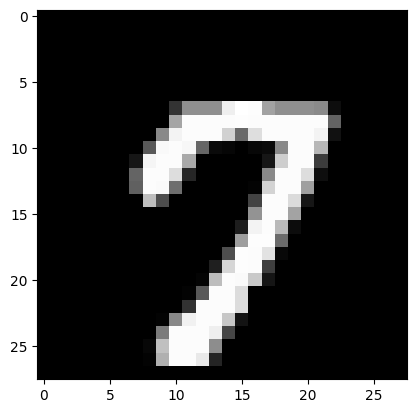

In [2]:
download = False
dataset_class = datasets.MNIST
mnist_transform = [transforms.ToTensor()]
# add normalization to the transform list such that all values are strictly greater than 0
mnist_transform.append(transforms.Lambda(lambda x: x + 1e-5))

dataset_transform = transforms.Compose(mnist_transform)
mnist_train = dataset_class('data/MNIST', train=True, download=download, transform=dataset_transform)
mnist_test = dataset_class('data/MNIST', train=False, download=download, transform=dataset_transform)

mnist_train_loader = DataLoader(mnist_train, batch_size=1, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=1, shuffle=True)

# test the dataloader
for i, (data, target) in enumerate(mnist_train_loader):
    print(data.shape, target)
    # print(data)
    # display the first image
    plt.imshow(data[0, 0].numpy(), cmap='gray')
    plt.show()
    break

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# randonly shuffle the training data
# mnist_train_loader = DataLoader(mnist_train, batch_size=8, shuffle=True)

torch.Size([1, 1, 28, 28]) tensor([5])


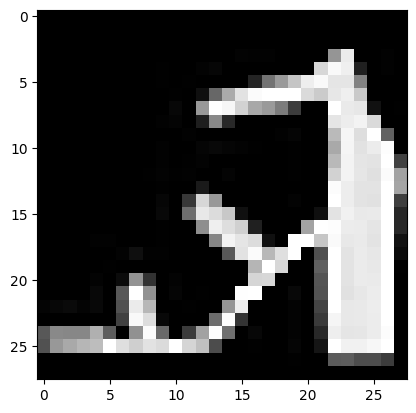

In [3]:
# load fashion mnist
download = False
dataset_class = datasets.FashionMNIST
fashion_mnist_transform = [transforms.ToTensor()]
# add normalization to the transform list such that all values are strictly greater than 0
# fashion_mnist_transform.append(transforms.Lambda(lambda x: x + 1e-6))

dataset_transform = transforms.Compose(fashion_mnist_transform)
fashion_mnist_train = dataset_class('data/FashionMNIST', train=True, download=download, transform=dataset_transform)
fashion_mnist_test = dataset_class('data/FashionMNIST', train=False, download=download, transform=dataset_transform)

fashion_mnist_train_loader = DataLoader(fashion_mnist_train, batch_size=1, shuffle=True)
fashion_mnist_test_loader = DataLoader(fashion_mnist_test, batch_size=1, shuffle=True)

# test the dataloader

for i, (data, target) in enumerate(fashion_mnist_train_loader):
    print(data.shape, target)
    # print(data)
    # display the first image
    plt.imshow(data[0, 0].numpy(), cmap='gray')
    plt.show()
    break


torch.Size([1, 3, 32, 32]) tensor([7])


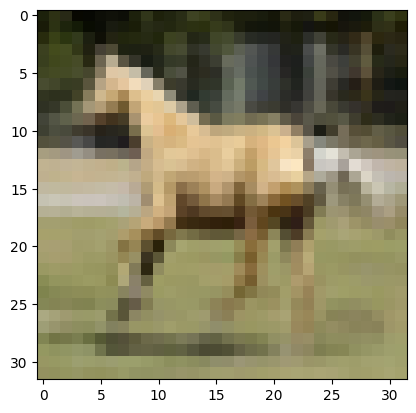

In [4]:
# load CIFAR10
download = False
dataset_class = datasets.CIFAR10
cifar10_transform = [transforms.ToTensor()]
# add normalization to the transform list such that all values are strictly greater than 0
# cifar10_transform.append(transforms.Lambda(lambda x: x + 1e-5))

dataset_transform = transforms.Compose(cifar10_transform)
cifar10_train = dataset_class('data/CIFAR10', train=True, download=download, transform=dataset_transform)
cifar10_test = dataset_class('data/CIFAR10', train=False, download=download, transform=dataset_transform)

cifar10_train_loader = DataLoader(cifar10_train, batch_size=1, shuffle=True)
cifar10_test_loader = DataLoader(cifar10_test, batch_size=1, shuffle=True)

# test the dataloader
for i, (data, target) in enumerate(cifar10_train_loader):
    print(data.shape, target)
    # print(data)
    # display the first image
    plt.imshow(data[0].permute(1, 2, 0).numpy())
    plt.show()
    break



## Multinode Prediction
- Use loss_fn_mode=0

In [5]:
def gumbel_softmax(logits, tau=1, hard=False, eps=1e-10, dim=-1):
    # type: (Tensor, float, bool, float, int) -> Tensor
    r"""
    Samples from the `Gumbel-Softmax distribution`_ and optionally discretizes.
    You can use this function to replace "F.gumbel_softmax".
    
    Args:
      logits: `[..., num_features]` unnormalized log probabilities
      tau: non-negative scalar temperature
      hard: if ``True``, the returned samples will be discretized as one-hot vectors,
            but will be differentiated as if it is the soft sample in autograd
      dim (int): A dimension along which softmax will be computed. Default: -1.
    Returns:
      Sampled tensor of same shape as `logits` from the Gumbel-Softmax distribution.
      If ``hard=True``, the returned samples will be one-hot, otherwise they will
      be probability distributions that sum to 1 across `dim`.
    .. note::
      This function is here for legacy reasons, may be removed from nn.Functional in the future.
    .. note::
      The main trick for `hard` is to do  `y_hard - y_soft.detach() + y_soft`
      It achieves two things:
      - makes the output value exactly one-hot
      (since we add then subtract y_soft value)
      - makes the gradient equal to y_soft gradient
      (since we strip all other gradients)
    Examples::
        >>> logits = torch.randn(20, 32)
        >>> # Sample soft categorical using reparametrization trick:
        >>> F.gumbel_softmax(logits, tau=1, hard=False)
        >>> # Sample hard categorical using "Straight-through" trick:
        >>> F.gumbel_softmax(logits, tau=1, hard=True)
    .. _Gumbel-Softmax distribution:
        https://arxiv.org/abs/1611.00712
        https://arxiv.org/abs/1611.01144
    """
    def _gen_gumbels():
        gumbels = -torch.empty_like(logits).exponential_().log()
        if torch.isnan(gumbels).sum() or torch.isinf(gumbels).sum():
            # to avoid zero in exp output
            gumbels = _gen_gumbels()
        return gumbels

    gumbels = _gen_gumbels()  # ~Gumbel(0,1)
    # print(gumbels)
    gumbels = (logits + gumbels) / tau  # ~Gumbel(logits,tau)
    # gumbels = logits / tau  # ~Gumbel(logits,tau)
    y_soft = gumbels.softmax(dim)

    if hard:
        # Straight through.
        index = y_soft.max(dim, keepdim=True)[1]
        y_hard = torch.zeros_like(logits).scatter_(dim, index, 1.0)
        ret = y_hard - y_soft.detach() + y_soft
    else:
        # Reparametrization trick.
        ret = y_soft
    return ret

In [6]:
p = [
    [1, 0, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
]
# p = torch.tensor(p, dtype=torch.float32)
# make sure they sum to 1 for each row
# print(p.view(4, -1, 2))
# p = F.softmax(p.sum(dim=0), dim=-1)
# print(p)

batch_size = (2 ** 7)

p = F.softmax(torch.rand(batch_size), dim=-1)
# print(p)

equ = 1 / batch_size


# ce with [0.5, 0.5] for both classes in the last dimension
# reg = - (0.5 * torch.log(p)).sum()
kl = F.kl_div(torch.log(p), torch.tensor([equ], dtype=torch.float32), reduction='sum')
# kl = F.kl_div(torch.log(torch.tensor(equ, dtype=torch.float32)), p, reduction='sum')

kl
# -reg.mean()

tensor(0.0397)

In [7]:
# custom cross entropy loss with input is softmax activated
def CrossEntropyLoss(input, target, reduction='none'):
    loss = -target * torch.log(input + 1e-10)
    if reduction == 'mean':
        return loss.mean()
    elif reduction == 'sum':
        return loss.sum()
    else:
        return loss

In [8]:
x = [[1,2,3,4], 
     [5,6,7,8]] # shape: (B, C)
y = [[9,10,11,12], 
     [13,14,15,16]]
x = torch.tensor(x)
y = torch.tensor(y)
z = torch.stack([x, y], dim=2).view(2, -1)
# z = torch.cat([x, y], dim=1)
print(z)
z.unsqueeze(2).expand(-1, -1, 2).reshape(2, -1)

tensor([[ 1,  9,  2, 10,  3, 11,  4, 12],
        [ 5, 13,  6, 14,  7, 15,  8, 16]])


tensor([[ 1,  1,  9,  9,  2,  2, 10, 10,  3,  3, 11, 11,  4,  4, 12, 12],
        [ 5,  5, 13, 13,  6,  6, 14, 14,  7,  7, 15, 15,  8,  8, 16, 16]])

# CobwebNN

In [13]:
class CobwebNNTreeLayer(nn.Module):
    def __init__(self, n_hidden, n_cluster, branch_factor=2, n_classes=10, tau=1, alpha=0.1):
        super().__init__()
        self.n_hidden = n_hidden
        self.n_cluster = n_cluster
        self.branch_factor = branch_factor
        self.n_classes = n_classes

        self.l_probs = nn.Linear(n_hidden, n_cluster)
        # self.l_probs = nn.Sequential(
        #     nn.Linear(n_hidden, n_hidden),
        #     # nn.Tanh(),
        #     nn.ReLU(),
        #     nn.Linear(n_hidden, n_cluster)
        # )
        
        # self.classifier_w = nn.Parameter(torch.rand(2*n_cluster, n_hidden, n_classes))
        # xavier initialization
        self.classifier_w = nn.Parameter(torch.nn.init.xavier_normal_(torch.empty(2*n_cluster, n_hidden, n_classes)))
        # self.classifier_b = nn.Parameter(torch.rand(2*n_cluster, n_classes))
        self.classifier_b = nn.Parameter(torch.nn.init.xavier_normal_(torch.empty(2*n_cluster, n_classes)))
        self.tau = tau
        self.alpha = alpha

        self.classifier = nn.Linear(n_hidden, n_classes)
    def forward(self, x, z, hard=False):
        '''
        z: parent probs in log-space. Shape: (batch_size, n_cluster)
        x: input data. Shape: (batch_size, n_hidden)
        '''
        B = x.size(0)

        x_l_probs = self.l_probs(x) # (B, n_cluster)
        x_l_probs = untils.GumbelSigmoid(x_l_probs, self.tau, self.alpha, hard=hard)
        x_r_probs = 1 - x_l_probs
        # interleave the probs. i.e, [x_l_probs1, x_r_probs1, x_l_probs2, x_r_probs2, ...]
        x_probs = torch.stack([x_l_probs, x_r_probs], dim=2).view(B, -1) # shape: (B, 2 * n_cluster)

        z = z.unsqueeze(2).expand(-1, -1, 2).reshape(B, -1)
        # z = z + torch.log(x_probs + 1e-10)
        z = z * x_probs
        # chain with parent probs

        # weighted_x = torch.exp(z.unsqueeze(2) + torch.log(x).unsqueeze(1)) # shape: (B, 2 * n_cluster, n_hidden)
        weighted_x = z.unsqueeze(2) * x.unsqueeze(1) 

        logits = torch.einsum('bch,chk->bck', weighted_x, self.classifier_w) + self.classifier_b # shape: (B, 2 * n_cluster, n_classes)
        return logits, z, x_probs, weighted_x
    
class CobwebNNTree(nn.Module):
    def __init__(self, n_layers=3, n_hidden=784, branch_factor=2, n_classes=10, loss_fn_mode=0, 
                 tau=1, alpha=0.1, lambda_=99, reg_decay=False):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.branch_factor = branch_factor
        self.n_classes = n_classes
        self.loss_fn_mode = loss_fn_mode
        self.lambda_ = lambda_
        self.reg_decay = reg_decay

        self.layers = nn.ModuleList(
            [CobwebNNTreeLayer(n_hidden, branch_factor**i, branch_factor, n_classes, tau, alpha) 
                               for i in range(0, n_layers)]
        )
        self.softmax = nn.Softmax(dim=-1)
        if self.loss_fn_mode == 1:
            self.CorssEntropyLoss = nn.CrossEntropyLoss(reduction='none')
        else:
            self.CorssEntropyLoss = nn.CrossEntropyLoss()
            # self.nll_loss = nn.NLLLoss()

    def forward(self, x, y=None, hard=False):
        x = x.view(-1, self.n_hidden)
        B = x.size(0)

        # z = torch.zeros(B, 1).to(x.device)
        z = torch.ones(B, 1).to(x.device)

        layer_logits = []
        layer_z = []
        layer_x_probs = []
        x_splits = []
        reg = 0
        for layer_idx, layer in enumerate(self.layers):
            logits, z, x_prob, x_split = layer(x, z, hard=hard)
            layer_logits.append(logits)
            layer_z.append(z)
            layer_x_probs.append(x_prob)
            x_splits.append(x_split)
            # print(z)

            reg += untils.cross_entropy_regularization(z, depth=layer_idx, lambda_=self.lambda_, n_layers=self.n_layers, decay=self.reg_decay)
            # print(f"Layer {layer_idx} reg: {reg}")

        loss = None
        logits = None
        # do loss computations
        if self.loss_fn_mode == 0:
            # FIrst loss, sum[CE[p(c|x)p(y|c), y]]
            weighted_logits = []
            for logits, z, x_prob in zip(layer_logits, layer_z, layer_x_probs):
                # logits = torch.exp(z).unsqueeze(2) * logits # shape: (B, 2 * n_cluster, n_classes)
                logits = z.unsqueeze(2) * logits # shape: (B, 2 * n_cluster, n_classes)
                weighted_logits.append(logits.sum(dim=1))
            weighted_logits = torch.stack(weighted_logits, dim=1).sum(dim=1) # shape: (B, n_classes)
            logits = weighted_logits
            if y is not None:
                loss = self.CorssEntropyLoss(weighted_logits, y)
                loss = loss + reg


        elif self.loss_fn_mode == 1:
            # second loss, sum[p(c|x) CE[p(y|c), y]]
            if y is not None:
                losses = []
                probs = []
                for logits, z, x_prob in zip(layer_logits, layer_z, layer_x_probs):
                    y_expanded = y.unsqueeze(1).repeat(1, logits.size(1)) # shape: (B, 2 * n_cluster)
                    cluster_loss = self.CorssEntropyLoss(logits.reshape(-1, self.n_classes), y_expanded.view(-1)) # shape: (B, 2 * n_cluster)
                    # cluster_loss = (torch.exp(z).view(-1) * cluster_loss)
                    cluster_loss = (z.view(-1) * cluster_loss)
                    cluster_loss = cluster_loss.view(B, -1).sum(dim=1) # shape: (B,)

                    prob = F.softmax(logits, dim=-1)
                    # prob = gumbel_softmax(logits, tau=0.1, hard=False)
                    # prob = prob * torch.exp(z.unsqueeze(2))
                    prob = prob * z.unsqueeze(2)
                    probs.append(prob)
                    losses.append(cluster_loss)

                loss = torch.cat(losses, dim=0).mean()
                logits = torch.cat(probs, dim=1).sum(dim=1)
                # print(loss, reg)
                loss =  reg + loss


        return untils.ModelOutput(loss=loss, logits=logits, debug_info={'layer_logits': layer_logits, 
                                                                        'x_splits': x_splits,
                                                                        'layer_z': layer_z})



In [11]:
x = torch.randn(2, 2)
# print(x)
x = x.view(2, 1, 2)
# print(x)
x = torch.nn.functional.gumbel_softmax(x, tau=0.1, hard=True, dim=2)
# print(x)
# x = torch.log(x)
# print(x)
left = x[:, :, 0]
right = x[:, :, 1]
# print(left, right)
x = torch.cat([left, right], dim=1)
print(x)

x = torch.randn(2, 4)
# print(x)
x = x.view(2, 2, 2)
# print(x)
x = torch.nn.functional.gumbel_softmax(x, tau=0.1, hard=True, dim=2)
# print(x)
# x = torch.log(x)
# print(x)
left = x[:, :, 0]
right = x[:, :, 1]
# print(left, right)
x = torch.cat([left, right], dim=1)
print(x)


tensor([[1., 0.],
        [1., 0.]])
tensor([[0., 1., 1., 0.],
        [0., 0., 1., 1.]])


In [12]:
x = [0.5, 0.48, 0.31, 0.4]
# y = [0.0, 1.0, 0.0, 0.0]
x = torch.tensor(x)
# y = torch.tensor(y)
# z = x + y
pred = gumbel_softmax(x, tau=0.1, hard=True, dim=0)
print(pred)
print(torch.argmax(pred))

tensor([1., 0., 0., 0.])
tensor(0)


In [13]:
y = F.softmax(x / 0.01, dim=0)
print(y)
print(torch.argmax(y))


tensor([8.8076e-01, 1.1920e-01, 4.9347e-09, 3.9987e-05])
tensor(0)


In [50]:
# only 1 and 0
hard = [4,5,7,9]
easy = [0,1,2,3]
longer = [0,1,2,3,4,5,6,7]
random_digit = [1, 4, 6, 8]
all_labels = list(range(10))

split = all_labels

mnist_01_train = untils.filter_by_label(mnist_train, split, rename_labels=True)
mnist_01_test = untils.filter_by_label(mnist_test, split, rename_labels=True)

100%|██████████| 10000/10000 [00:00<00:00, 61514.58it/s]


Epoch 10/10: 100%|██████████| 235/235 [00:12<00:00, 19.16it/s, loss=0.856]


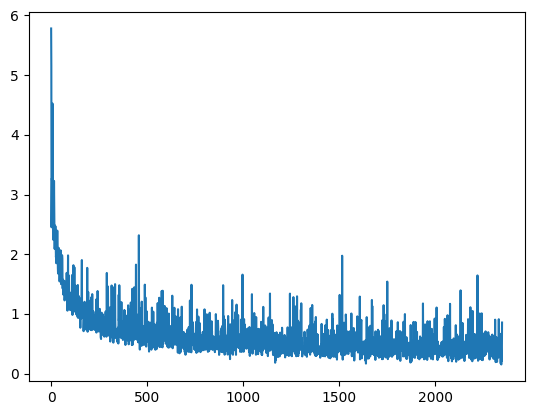

In [58]:
n_layers = 7
model = CobwebNNTree(n_layers=n_layers, branch_factor=2, n_hidden=28*28, n_classes=10, loss_fn_mode=1, 
                     tau=0.01, alpha=0.3, lambda_=99, reg_decay=False)
# model = CobwebSparse(n_layers=n_layers, branch_factor=2, n_input=64).to('cuda')

model.to('mps')
optimizer = optim.Adam(model.parameters(), lr=1e-3)

untils.train_model(model, mnist_01_train, True, optimizer, epochs=10, hard=False, batch_size=256, show_loss=True, 
                   device='mps', verbose=False, early_break=False)



- lr=1e3, batch=256, n_layers=8, 12 epochs, gives 97.37%

In [55]:
untils.test_model(model, mnist_01_test, device='mps', batch_size=256, hard=True)

Accuracy: 0.9517


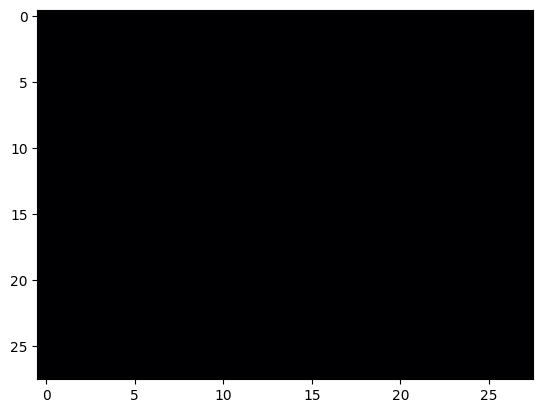

In [ ]:
cmap="inferno"
array = torch.ones(28*28).numpy().reshape(28, 28) - 0.5
# print(array)
# random number form 0 to 1
array = np.ones((28, 28))
plt.imshow(array, cmap=cmap, aspect="auto")
plt.show()

## Visualization

In [56]:
import base64
import matplotlib.pyplot as plt
from io import BytesIO
import json

def tensor_to_base64(tensor, shape, cmap="gray", normalize=False):
    array = tensor.numpy().reshape(shape)
    if normalize:
        plt.imshow(array, cmap=cmap, aspect="auto")
    else:
        plt.imshow(array, cmap=cmap, aspect="auto", vmin=0, vmax=1)

    plt.axis("off")

    buf = BytesIO()
    plt.savefig(buf, format="png", bbox_inches="tight", pad_inches=0)
    plt.close()
    
    buf.seek(0)
    return base64.b64encode(buf.getvalue()).decode("utf-8")

def process_tree(data_layer_list, dist_layer_list, image_shape, dist_shape):
    '''
    layer_list: list of list of tensors. Each list of tensors corresponds to a layer in the tree
    The tree is a complete binary tree with branching factor 2
    '''

    child_idx = 1

    root = {
        "node_id": "0",
        "image": tensor_to_base64(torch.zeros(image_shape), image_shape, cmap="inferno"),
        "dist_image": tensor_to_base64(torch.zeros(dist_shape), dist_shape, cmap="viridis"),
        "children": []
    }

    parents = [root]
    for data_list, dist_list in zip(data_layer_list, dist_layer_list):
        children_count = 0
        parent = None
        new_parents = []
        for data, dist in zip(data_list, dist_list):
            if children_count % 2 == 0:
                parent = parents.pop(0)
            parent["children"].append({
                "node_id": str(child_idx),
                "image": tensor_to_base64(data, image_shape, cmap="inferno", normalize=True),
                "dist_image": tensor_to_base64(dist, dist_shape, cmap="viridis", normalize=True),
                "children": []
            })
            child_idx += 1
            children_count += 1
            new_parents.append(parent["children"][-1])
        parents = new_parents

    return root


def get_tree_data(model=None, test_data=None, n_layers=None, filename=None, image_shape=None, dist_shape=None):
    x_splits = []
    layer_logits = []
    layer_z = []

    test_loader = DataLoader(test_data, batch_size=512, shuffle=True)

    model.eval()
    with torch.no_grad():
        # x, y = test_data
        for x, y in tqdm(test_loader):
            outputs = model(x.to('mps'), hard=True)
            x_splits.append(torch.cat([x_split.detach().cpu() for x_split in outputs.debug_info['x_splits']], dim=1))
            layer_logits.append(torch.cat([logits.detach().cpu() for logits in outputs.debug_info['layer_logits']], dim=1))
            layer_z.append(torch.cat([z.detach().cpu() for z in outputs.debug_info['layer_z']], dim=1))
            # break
        # print(outputs.debug_info['layer_z'][1].shape)

    x_splits = torch.cat(x_splits, dim=0) # shape of x_splits: [batch, 2 * n_clusters, n_hidden]
    layer_logits = torch.cat(layer_logits, dim=0) # shape of layer_logits: [batch, 2 * n_clusters, n_classes]
    layer_z = torch.cat(layer_z, dim=0) # shape of layer_z: [batch, 2 * n_clusters, n_hidden]
    # print(f"x_splits: {x_splits.shape}, layer_logits: {layer_logits.shape}, layer_z: {layer_z.shape}")

    # shape of x_splits: [batch, n_clusters ** 2 - 2, n_hidden]

    tree_x_splits = []
    tree_layer_logits = []
    tree_layer_z = []

    for i in range(1, n_layers+1): # 2 to 32, or 1 to 5
        n_clusters = 2 ** (i + 1) - 2 # 2, 6, 14, 30
        n_clusters_prev = 2 ** i - 2 # 0, 2, 6, 14

        x_split = x_splits[:, n_clusters_prev:n_clusters] # shape: [batch, n_clusters, n_hidden]
        layer_logit = layer_logits[:, n_clusters_prev:n_clusters]
        layer_z_ = layer_z[:, n_clusters_prev:n_clusters]

        # both x_splits and layer_logits are organized as follows (the n_clusters dimension):
        # [left1, left2, ..., leftN, right1, right2, ..., rightN]
        # want to reorganize them in complete binary tree order as follows:
        # [left1, right1, left2, right2, ..., leftN, rightN]

        # print(x_split.shape)
        # print(layer_logit.shape)
        # print(layer_z_.shape)
        # print('\n')
        # print(x_split)
        x_split = x_split.sum(dim=0) / layer_z_.sum(dim=0).unsqueeze(1) # shape: [n_clusters, n_hidden]
        layer_logit = torch.nn.functional.softmax(layer_logit.mean(dim=0), dim=1) # shape: [n_clusters, n_classes]
        
        # weighted_x_ = weighted_x.detach().sum(dim=0) / z.detach().sum(dim=0).unsqueeze(1)
        plt.figure(figsize=(x_split.size(0), 5))
        plt.imshow(torch.cat([x_split[i].view(28, 28).cpu().detach() for i in range(x_split.size(0))], dim=1).cpu().detach().numpy(), cmap='inferno')
        plt.show()
        # print(x_split.shape)
        # print(layer_logit.shape)
        # print(layer_z_.shape)
        # print('\n')

        x_split_temp = []
        layer_logit_temp = []
        layer_z_temp = []

        n_clusters = x_split.size(0)

        for j in range(n_clusters):
            x_split_temp.append(x_split[j])
            # x_split_temp.append(x_split[j + n_clusters // 2])

            layer_logit_temp.append(layer_logit[j])
            # layer_logit_temp.append(layer_logit[j + n_clusters // 2])

            layer_z_temp.append(layer_z_[:, j])
            # layer_z_temp.append(layer_z_[:, j + n_clusters // 2])
        
        tree_x_splits.append(x_split_temp)
        tree_layer_logits.append(layer_logit_temp)
        tree_layer_z.append(layer_z_temp)
        # print([z for z in layer_z_temp])
        # print([x_split_temp[i] for i in range(len(x_split_temp))])


    root = process_tree(tree_x_splits, tree_layer_logits, image_shape, dist_shape)

    with open(filename, "w") as f:
        json.dump(root, f, indent=2)
        
        
    
    








100%|██████████| 20/20 [00:04<00:00,  4.41it/s]


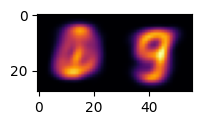

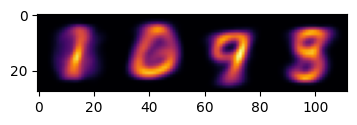

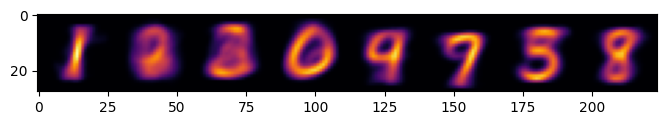

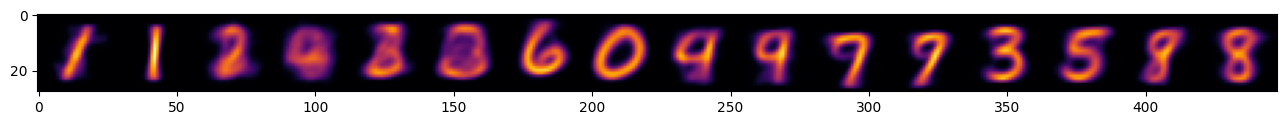

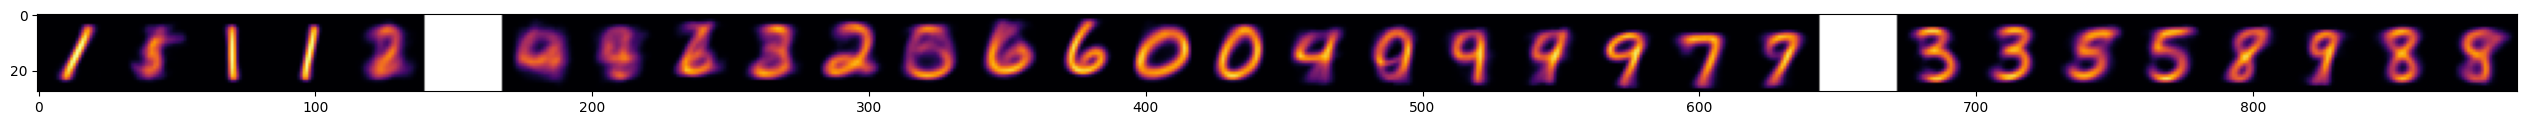

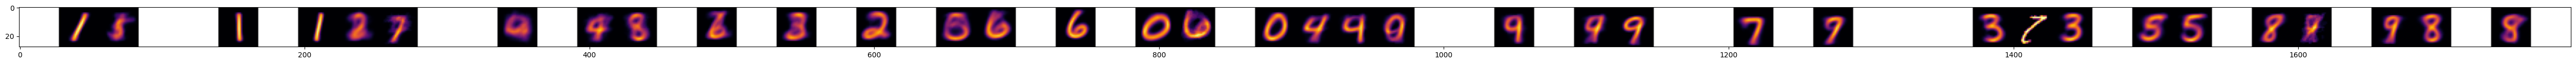

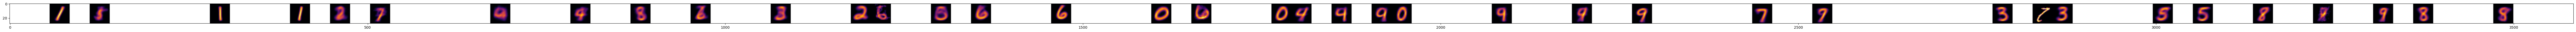

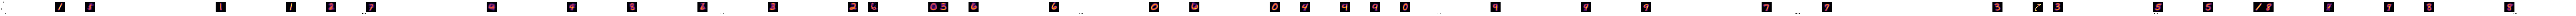

In [57]:
get_tree_data(model, mnist_01_test, n_layers=n_layers, filename="test.json", image_shape=(28, 28), dist_shape=(1, 10))

In [ ]:
mnist_test_loader = DataLoader(mnist_test, batch_size=512, shuffle=True)
for test_data in mnist_test_loader:
    get_tree_data(model, test_data, n_layers=n_layers, filename="test.json", image_shape=(28, 28), dist_shape=(1, 10))
    break

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


RuntimeError: stack expects each tensor to be equal size, but got [512] at entry 0 and [512, 1, 28, 28] at entry 1

In [ ]:
# test single node prediction
def test_model(model, test_data, device='cuda', batch_size=32):
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

    labels = []
    layer_argmax = []
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(test_loader):
            outputs = model(x.to(device))
            layer_logits = outputs.debug_info['layer_logits']
            cluster_preds = torch.cat([logits.detach().cpu().argmax(dim=-1) for logits in layer_logits], dim=1)
            layer_argmax.append(cluster_preds)
            labels.extend(y.tolist())

        # concat the predictions of all batches
        layer_argmax = torch.cat(layer_argmax, dim=0) # shape: (N, 2**n_layers)
        labels = torch.tensor(labels).view(-1, 1).repeat(1, layer_argmax.size(1))
        correct = (layer_argmax == labels).sum(dim=0)
        accuracy = correct.float() / len(labels) # shape: (2**n_layers)
        return accuracy
    
accuracy = test_model(model, cifar10_test, device='cuda', batch_size=256)
print(accuracy)

100%|██████████| 40/40 [00:02<00:00, 19.03it/s]

tensor([0.3581, 0.3517, 0.3738, 0.3657, 0.3798, 0.3692, 0.3828, 0.2580, 0.3747,
        0.3822, 0.1000, 0.2884, 0.1000, 0.3775, 0.2319, 0.2121, 0.2440, 0.3838,
        0.0999, 0.2835, 0.1000, 0.1000, 0.2745, 0.1001, 0.2794, 0.1000, 0.1000,
        0.1000, 0.1000, 0.3828, 0.1849, 0.2652, 0.1000, 0.3848, 0.1000, 0.1002,
        0.1000, 0.1000, 0.2825, 0.1000, 0.2538, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1870, 0.1000, 0.2467, 0.1000, 0.1000, 0.2978, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1185, 0.1000, 0.1000, 0.1000, 0.1000, 0.3853, 0.2361,
        0.1000, 0.1000, 0.2987, 0.1000, 0.1002, 0.1000, 0.1000, 0.1000, 0.1000,
        0.3074, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1733, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1162, 0.1000,
        0.1000, 0.1000, 0.1000, 0.2566, 0.1000, 0.2612, 0.1000, 0.2142, 0.1000,
        0.1000, 0.1000, 0.1000, 0.2973, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 

In [ ]:
# display a binary tree like structure of accuracy. There is no root and it starts with the first layer (2 nodes)
def display_accuracy(accuracy, n_layers):
    n_nodes = 2 ** n_layers
    for i in range(1, n_layers + 1):
        print(f'Layer {i}')
        for j in range(2 ** i):
            print(f'{accuracy[j]:.2f}', end=' ')
        print()
        accuracy = accuracy[2 ** i:]

display_accuracy(accuracy, n_layers)


Layer 1
0.36 0.35 
Layer 2
0.37 0.37 0.38 0.37 
Layer 3
0.38 0.26 0.37 0.38 0.10 0.29 0.10 0.38 
Layer 4
0.23 0.21 0.24 0.38 0.10 0.28 0.10 0.10 0.27 0.10 0.28 0.10 0.10 0.10 0.10 0.38 
Layer 5
0.18 0.27 0.10 0.38 0.10 0.10 0.10 0.10 0.28 0.10 0.25 0.10 0.10 0.10 0.10 0.10 0.19 0.10 0.25 0.10 0.10 0.30 0.10 0.10 0.10 0.10 0.12 0.10 0.10 0.10 0.10 0.39 
Layer 6
0.24 0.10 0.10 0.30 0.10 0.10 0.10 0.10 0.10 0.10 0.31 0.10 0.10 0.10 0.10 0.10 0.17 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.12 0.10 0.10 0.10 0.10 0.26 0.10 0.26 0.10 0.21 0.10 0.10 0.10 0.10 0.30 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.25 0.10 0.10 0.30 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.26 
Layer 7
0.20 0.10 0.10 0.13 0.10 0.10 0.10 0.10 0.10 0.10 0.28 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.16 0.10 0.10 0.10 0.10 0.10 0.10 0.11 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.25 0.10 0.10 0.10 0.10 0.10 0.10 0.10 0.1

In [ ]:
display_accuracy(accuracy, n_layers)


NameError: name 'display_accuracy' is not defined